In [45]:
import pandas as pd
import json
import numpy as np
import os

from scipy.stats import entropy

### Xóa cột coefficient, language_id. Đổi tên cột assignment_id, problem_id, username

In [60]:
def parse_judgement(j):
    try:
        parsed = json.loads(j)
        verdicts = parsed.get("verdicts", {})
        times = parsed.get("times", [])
        mems = parsed.get("mems", [])

        total_verdicts = sum(verdicts.values())
        avg_time_case = np.mean(times) if times else 0
        avg_mem_case = np.mean(mems) if mems else 0

        # Entropy calculation (with safeguard against divide-by-zero)
        if total_verdicts > 0:
            probs = np.array([v / total_verdicts for v in verdicts.values()])
            verdict_entropy = -np.sum(probs * np.log2(probs))
        else:
            verdict_entropy = 0

        return pd.Series({
            'num_wrong': verdicts.get('WRONG', 0),
            'num_verdicts': total_verdicts,
            'avg_time_case': avg_time_case,
            'avg_mem_case': avg_mem_case,
            'verdict_entropy': verdict_entropy
        })

    except Exception as e:
        return pd.Series({
            'num_wrong': 0,
            'num_verdicts': 0,
            'avg_time_case': 0,
            'avg_mem_case': 0,
            'verdict_entropy': 0
        })

In [192]:
df = pd.read_csv('./result_v1/data_cleaned.csv')

df['created_at'] = pd.to_datetime(df['created_at'], format='%m-%d %H:%M:%S', errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], format='%m-%d %H:%M:%S', errors='coerce')

# Fix overnight judging
df.loc[df['updated_at'] < df['created_at'], 'updated_at'] += pd.Timedelta(days=1)

# Calculate duration
df['duration'] = (df['updated_at'] - df['created_at']).dt.total_seconds()

# Extract hour of submission
df['submit_hour'] = df['created_at'].dt.hour

#Parge judgement to more readable
df = pd.concat([df, df['judgement'].apply(parse_judgement)], axis=1)

#Extract and calculate features
df_summary = df.groupby('username').agg(
    total_submissions=('username', 'count'),
    total_problems=('problem_id', 'nunique'),
    total_assignments=('assignment_id', 'nunique'),

    final_ratio=('is_final', 'mean'),
    avg_duration=('duration', 'mean'),
    max_duration=('duration', 'max'),

    avg_submit_hour=('submit_hour', 'mean'),
    early_bird_ratio=('submit_hour', lambda x: (x < 12).sum() / len(x)),
    night_owl_ratio=('submit_hour', lambda x: (x >= 20).sum() / len(x)),

    avg_score=('pre_score', 'mean'),
    std_score=('pre_score', 'std'),
    best_score=('pre_score', 'max'),
    score_status_ratio=('status', lambda x: (x == 'SCORE').sum() / len(x)),

    problem_revisit_ratio=('problem_id', lambda x: len(x) / x.nunique() if x.nunique() else 0),
    avg_wrong=('num_wrong', 'mean'),
    avg_verdicts=('num_verdicts', 'mean'),
    avg_time_per_case=('avg_time_case', 'mean'),
    avg_mem_per_case=('avg_mem_case', 'mean'),
    avg_verdict_entropy=('verdict_entropy', 'mean'),
    avg_attempts_per_problem=('problem_id', lambda x: len(x) / x.nunique() if x.nunique() else 0),
).reset_index()

#Score progression trend
df_sorted = df.sort_values(['username', 'problem_id', 'created_at'])
df_sorted['score_diff'] = df_sorted.groupby(['username', 'problem_id'])['pre_score'].diff()
score_trend = df_sorted.groupby(['username', 'problem_id'])['score_diff'].mean().groupby('username').mean()
score_trend.name = 'avg_score_progression'

#Avg time spent per problem
df_times = df.sort_values(['username', 'problem_id', 'created_at'])
problem_time = df_times.groupby(['username', 'problem_id'])['created_at'].agg(['min', 'max'])
problem_time['duration'] = (pd.to_datetime(problem_time['max']) - pd.to_datetime(problem_time['min'])).dt.total_seconds()
user_avg_duration = problem_time.groupby('username')['duration'].mean()
user_avg_duration.name = 'avg_problem_duration'

#Verdict diversity (how many unique verdicts per user)
def count_verdict_types(judgement_list):
    verdicts = []
    for js in judgement_list:
        try:
            verdicts.append(list(eval(js)['verdicts'].keys()))
        except:
            continue
    return len(set([v for vs in verdicts for v in vs]))

verdict_diversity = df.groupby('username')['judgement'].apply(count_verdict_types)
verdict_diversity.name = 'verdict_diversity'

#Avg score improvement to final
final_scores = df[df['is_final'] == 1].groupby(['username', 'problem_id'])['pre_score'].first()
first_scores = df.groupby(['username', 'problem_id'])['pre_score'].first()
score_improvement = (final_scores - first_scores).groupby('username').mean()
score_improvement.name = 'avg_score_improvement_to_final'

#Score volatility per problem
score_volatility = df.groupby(['username', 'problem_id'])['pre_score'].std().groupby('username').mean()
score_volatility.name = 'avg_score_volatility_per_problem'

#Time gap before final submission
df_sorted = df.sort_values(['username', 'problem_id', 'created_at'])
finals = df_sorted[df_sorted['is_final'] == 1].copy()
finals['prev_time'] = df_sorted.groupby(['username', 'problem_id'])['created_at'].shift(1)
finals['gap_to_final_sec'] = (
    pd.to_datetime(finals['created_at']) - pd.to_datetime(finals['prev_time'])
).dt.total_seconds()
final_submit_gap_avg = finals.groupby('username')['gap_to_final_sec'].mean()
final_submit_gap_avg.name = 'avg_gap_before_final_submission'

#Suspiciously perfect problems ratio
problem_stats = df.groupby(['username', 'problem_id']).agg(
    attempts=('pre_score', 'count'),
    final_score=('pre_score', lambda x: x.iloc[-1])
)
suspicious = (problem_stats['attempts'] == 1) & (problem_stats['final_score'] == 10000)
suspicious_ratio = suspicious.groupby('username').mean()
suspicious_ratio.name = 'suspiciously_perfect_problems_ratio'

#Submit time entropy
def submit_entropy(x):
    hour_counts = x.value_counts(normalize=True)
    return entropy(hour_counts)

submit_time_entropy = df.groupby('username')['submit_hour'].apply(submit_entropy)
submit_time_entropy.name = 'submit_time_entropy'

df['submit_date'] = df['created_at'].dt.floor('d')
active_days = df.groupby('username')['submit_date'].nunique()
active_days.name = 'active_days'

activity_span = df.groupby('username')['submit_date'].agg(['min', 'max'])
activity_span['activity_days_span'] = (activity_span['max'] - activity_span['min']).dt.days + 1
activity_span = activity_span['activity_days_span']

df_sorted_user = df.sort_values(['username', 'created_at'])
global_score_diff = df_sorted_user.groupby('username')['pre_score'].apply(lambda x: x.diff().mean())
global_score_diff.name = 'avg_global_score_improvement'

final_quality = df[df['is_final'] == 1].groupby('username')['pre_score'].mean() / 10000
final_quality.name = 'final_score_ratio'

submission_attempts = df.groupby(['username', 'problem_id']).size()
final_submissions = df[df['is_final'] == 1].groupby(['username', 'problem_id']).size()
struggle_ratio = (submission_attempts - final_submissions).groupby('username').mean()
struggle_ratio.name = 'avg_attempts_before_final'

late_ratio = (df['submit_hour'] >= 22).groupby(df['username']).mean()
late_ratio.name = 'late_night_submit_ratio'

assign_done = df[df['is_final'] == 1].groupby(['username', 'assignment_id']).size().groupby('username').count()
assign_total = df.groupby(['username', 'assignment_id']).size().groupby('username').count()
assignment_completion = assign_done / assign_total
assignment_completion.name = 'assignment_completion_ratio'

first_scores = df.groupby(['username', 'problem_id'])['pre_score'].first()
final_scores = df[df['is_final'] == 1].groupby(['username', 'problem_id'])['pre_score'].last()
score_gain = (final_scores - first_scores).groupby('username').mean()
score_gain.name = 'avg_score_improvement'

df_sorted = df.sort_values(['username', 'created_at'])
global_score_diff = df_sorted.groupby('username')['pre_score'].apply(lambda x: x.diff().mean())
global_score_diff.name = 'avg_score_trend'

efficiency = (1 / submission_attempts).groupby('username').mean()
efficiency.name = 'avg_efficiency_per_problem'


df['weekday'] = df['created_at'].dt.weekday
weekend_ratio = (df['weekday'] >= 5).groupby(df['username']).mean()
weekend_ratio.name = 'weekend_submit_ratio'

def max_streak(submit_dates):
    dates = sorted(set(submit_dates))
    streak, max_streak = 1, 1
    for i in range(1, len(dates)):
        if (dates[i] - dates[i-1]).days == 1:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 1
    return max_streak

streak_days = df.groupby('username')['submit_date'].apply(lambda x: max_streak(list(x)))
streak_days.name = 'max_streak_days'

def error_recovery_ratio(user_df):
    user_df = user_df.sort_values('created_at')
    count = 0
    total = 0
    for i in range(1, len(user_df)):
        if user_df.iloc[i - 1]['status'] == 'Compilation Error':
            total += 1
            if user_df.iloc[i]['pre_score'] == 10000:
                count += 1
    return pd.Series({'compilation_recovery_ratio': count / total if total > 0 else 0})
recovery_ratio = (
    df.drop(columns='username')
      .groupby(df['username'], group_keys=False)
      .apply(error_recovery_ratio)
      .reset_index()
)

# Problem switching frequency
df_sorted = df.sort_values(['username', 'created_at'])
problem_changes = (df_sorted.groupby('username')['problem_id']
                  .apply(lambda x: (x != x.shift()).sum())
                  .reset_index(name='problem_switches'))

# Focus intensity (submissions/problem/day)
focus_intensity = (
    df.groupby(['username', 'submit_date', 'problem_id']).size()
    .groupby('username').mean()
    .reset_index(name='avg_submissions_per_problem_per_day')
)

#Merge all into df_summary
df_summary = (
    df_summary
    .merge(score_improvement, on='username', how='left')
    .merge(score_volatility, on='username', how='left')
    .merge(final_submit_gap_avg, on='username', how='left')
    .merge(suspicious_ratio, on='username', how='left')
    .merge(submit_time_entropy, on='username', how='left')
    .merge(score_trend, on='username', how='left')
    .merge(user_avg_duration, on='username', how='left')
    .merge(verdict_diversity, on='username', how='left')

    #13 score mark
    .merge(active_days, on='username', how='left')
    .merge(activity_span, on='username', how='left')
    .merge(global_score_diff, on='username', how='left')
    .merge(final_quality, on='username', how='left')
    .merge(struggle_ratio, on='username', how='left')
    .merge(late_ratio, on='username', how='left')
    .merge(assignment_completion, on='username', how='left')
    .merge(efficiency, on='username', how='left')
    .merge(weekend_ratio, on='username', how='left')
    .merge(streak_days, on='username', how='left')
    .merge(recovery_ratio, on='username', how='left')

    .merge(problem_changes, on='username', how='left')
    .merge(focus_intensity, on='username', how='left')
)

df_summary.to_csv('./result_v1/user_with_features.csv', index=False)

In [194]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load the already extracted features
agg = pd.read_csv('./result_v1/user_with_features.csv')

# Separate identifier column
user_ids = agg['username']
features = agg.drop(columns=['username'])

# Initialize scaler (scales values to 0–1)
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Recreate DataFrame with original column names
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df.insert(0, 'username', user_ids)

# Save normalized features
normalized_df.to_csv('./result_v1/user_with_features_normalized.csv', index=False)

In [193]:
FEATURE_CSV = r'.\result_v1\user_with_features_normalized.csv'
RESULT_FOLDER = r'.\result_v1'
QT_FOLDER = r'.\result_v1\qt'

### Lọc file điểm qt

In [171]:
df_scores = pd.read_csv(r'.\data\qt-public.csv')
df = df_scores.dropna(subset=['diemqt'])
df.to_csv(r'.\result_v1\qt\qt_public_cleaned.csv', index=False)

df_features = pd.read_csv(FEATURE_CSV)
df_scores = pd.read_csv(os.path.join(QT_FOLDER, 'qt_public_cleaned.csv'))
df_scores.rename(columns={'hash': 'username'}, inplace=True)

# 1. user_without_features: users có trong features nhưng không có trong scores
users_features = set(df_features['username'])
users_scores = set(df_scores['username'])

users_without_scores = users_features - users_scores  # tập user có trong features nhưng không trong scores

df_user_without_features = df_features[df_features['username'].isin(users_without_scores)]

# 2. user_with_features: users có trong cả 2 file, lưu toàn bộ cột (merge trên username)
df_user_with_features = pd.merge(df_scores, df_features, on='username', how='inner')

df_user_without_features[['username']].to_csv(os.path.join(QT_FOLDER, "user_qt_without_features.csv"), index=False)
df_user_with_features.to_csv(os.path.join(QT_FOLDER, "user_qt_with_features.csv"), index=False)
df_user_with_features.isnull().sum()
df_user_without_features.isnull().sum()

username                                0
total_submissions                       0
total_problems                          0
total_assignments                       0
final_ratio                             0
avg_duration                            0
max_duration                            0
avg_submit_hour                         0
early_bird_ratio                        0
night_owl_ratio                         0
avg_score                               0
std_score                               6
best_score                              0
score_status_ratio                      0
problem_revisit_ratio                   0
avg_wrong                               0
avg_verdicts                            0
avg_time_per_case                       0
avg_mem_per_case                        0
avg_verdict_entropy                     0
avg_attempts_per_problem                0
avg_score_improvement_to_final          1
avg_score_volatility_per_problem        7
avg_gap_before_final_submission   

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [172]:
# Đọc file
df = pd.read_csv(os.path.join(QT_FOLDER, "user_qt_with_features.csv"))
target_col = 'diemqt'

# Lọc features: bỏ cột username và cột target
X = df.drop(columns=['username', 'diemqt'])
y = df[target_col]

X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Save features to file
feature_cols = X_train.columns.tolist()
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)

# Khởi tạo và train model
model = RandomForestRegressor()
model.fit(X_train, y_train)


# Dự đoán trên tập test
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2:.4f}')


R^2 Score: 0.1127


In [173]:
# 1. Đọc dữ liệu
df_features = pd.read_csv(FEATURE_CSV)
df_without_features = pd.read_csv(r'.\result_v1\qt\user_qt_without_features.csv')

df_to_predict = df_features[df_features['username'].isin(df_without_features['username'])].copy()
df_to_predict['std_score'] = df_to_predict['std_score'].fillna(0)

# Xác định các cột đặc trưng
with open('feature_columns.json') as f:
    feature_cols = json.load(f)

# Dự đoán
df_to_predict['predicted_score'] = model.predict(df_to_predict[feature_cols])

df_to_predict[['username', 'predicted_score']].to_csv(os.path.join(QT_FOLDER, "qt_submit_v2.csv"), index=False)

In [38]:
print(df_to_predict[feature_cols].isna().sum())

total_submissions        0
total_problems           0
total_assignments        0
final_ratio              0
avg_duration             0
max_duration             0
avg_submit_hour          0
early_bird_ratio         0
night_owl_ratio          0
avg_score                0
std_score                6
best_score               0
score_status_ratio       0
problem_revisit_ratio    0
avg_wrong                0
avg_verdicts             0
avg_time_per_case        0
avg_mem_per_case         0
avg_verdict_entropy      0
dtype: int64


### Điểm thực hành

In [189]:
df_scores = pd.read_csv(r'.\data\th-public.csv')
df = df_scores.dropna(subset=['TH'])
df.to_csv(r'.\result_v1\th\th-public-cleaned.csv', index=False)

df_features = pd.read_csv(FEATURE_CSV)
df_scores = pd.read_csv(r'.\result_v1\th\th-public-cleaned.csv')
df_scores.rename(columns={'hash': 'username'}, inplace=True)

# 1. user_without_features: users có trong features nhưng không có trong scores
users_features = set(df_features['username'])
users_scores = set(df_scores['username'])

users_without_scores = users_features - users_scores  # tập user có trong features nhưng không trong scores

df_user_without_features = df_features[df_features['username'].isin(users_without_scores)]

# 2. user_with_features: users có trong cả 2 file, lưu toàn bộ cột (merge trên username)
df_user_with_features = pd.merge(df_scores, df_features, on='username', how='inner')

# Lưu ra file
df_user_without_features[['username']].to_csv(r'.\result_v1\th\user_th_without_features.csv', index=False)
df_user_with_features.to_csv(r'.\result_v1\th\user_th_with_features.csv', index=False)
df_user_with_features.isnull().sum()  # Kiểm tra có cột nào bị thiếu không
df_user_without_features.isnull().sum()

username                                0
total_submissions                       0
total_problems                          0
total_assignments                       0
final_ratio                             0
avg_duration                            0
max_duration                            0
avg_submit_hour                         0
early_bird_ratio                        0
night_owl_ratio                         0
avg_score                               0
std_score                               6
best_score                              0
score_status_ratio                      0
problem_revisit_ratio                   0
avg_wrong                               0
avg_verdicts                            0
avg_time_per_case                       0
avg_mem_per_case                        0
avg_verdict_entropy                     0
avg_attempts_per_problem                0
avg_score_improvement_to_final          1
avg_score_volatility_per_problem        7
avg_gap_before_final_submission   

In [197]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Đọc file
df = pd.read_csv(r'.\result_v1\th\user_th_with_features.csv')

target_col = 'TH'

# Drop username & target from features
X = df.drop(columns=['username', target_col])
y = pd.to_numeric(df[target_col], errors='coerce')

# Drop rows with any NaNs in either X or y
combined = pd.concat([X, y], axis=1).dropna()

X_clean = combined.drop(columns=[target_col])
y_clean = combined[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.3, random_state=0)

feature_cols = X_train.columns.tolist()
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2:.4f}')


R^2 Score: 0.4017


In [200]:
# 1. Đọc dữ liệu
df_features = pd.read_csv(FEATURE_CSV)
df_without_features = pd.read_csv(r'.\result_v1\th\user_th_without_features.csv')

df_to_predict = df_features[df_features['username'].isin(df_without_features['username'])].copy()

# Xác định các cột đặc trưng
with open('feature_columns.json') as f:
    feature_cols = json.load(f)

df_to_predict['predicted_score'] = model.predict(df_to_predict[feature_cols])
df_to_predict[['username', 'predicted_score']].to_csv(r'.\result_v1\th\th_submit_1.csv', index=False)

### Điểm cuối kì

In [201]:
df_scores = pd.read_csv(r'.\data\ck-public.csv')
df = df_scores.dropna(subset=['CK'])
df.to_csv(r'.\result_v1\ck\ck-public-cleaned.csv', index=False)

df_features = pd.read_csv(FEATURE_CSV)
df_scores = pd.read_csv(r'.\result_v1\ck\ck-public-cleaned.csv')
df_scores.rename(columns={'hash': 'username'}, inplace=True)

# 1. user_without_features: users có trong features nhưng không có trong scores
users_features = set(df_features['username'])
users_scores = set(df_scores['username'])

users_without_scores = users_features - users_scores  # tập user có trong features nhưng không trong scores

df_user_without_features = df_features[df_features['username'].isin(users_without_scores)]

# 2. user_with_features: users có trong cả 2 file, lưu toàn bộ cột (merge trên username)
df_user_with_features = pd.merge(df_scores, df_features, on='username', how='inner')

# Lưu ra file
df_user_without_features[['username']].to_csv(r'.\result_v1\ck\user_ck_without_features.csv', index=False)
df_user_with_features.to_csv(r'.\result_v1\ck\user_ck_with_features.csv', index=False)
df_user_with_features.isnull().sum()
df_user_without_features.isnull().sum()

username                                0
total_submissions                       0
total_problems                          0
total_assignments                       0
final_ratio                             0
avg_duration                            0
max_duration                            0
avg_submit_hour                         0
early_bird_ratio                        0
night_owl_ratio                         0
avg_score                               0
std_score                               6
best_score                              0
score_status_ratio                      0
problem_revisit_ratio                   0
avg_wrong                               0
avg_verdicts                            0
avg_time_per_case                       0
avg_mem_per_case                        0
avg_verdict_entropy                     0
avg_attempts_per_problem                0
avg_score_improvement_to_final          1
avg_score_volatility_per_problem        7
avg_gap_before_final_submission   

In [203]:
# Đọc file
df = pd.read_csv(r'.\result_v1\ck\user_ck_with_features.csv')

target_col = 'CK'

# Lọc features: bỏ cột username và cột target
X = df.drop(columns=['username', 'CK'])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

feature_cols = X_train.columns.tolist()
with open('feature_columns.json', 'w') as f:
    json.dump(feature_cols, f)

# Khởi tạo và train model
model = RandomForestRegressor()
model.fit(X_train, y_train)


# Dự đoán trên tập test
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2:.4f}')

R^2 Score: 0.3581


In [206]:
# 1. Đọc dữ liệu
df_features = pd.read_csv(FEATURE_CSV)
df_without_features = pd.read_csv(r'.\result_v1\ck\user_ck_without_features.csv')

df_to_predict = df_features[df_features['username'].isin(df_without_features['username'])].copy()

# Xác định các cột đặc trưng
with open('feature_columns.json') as f:
    feature_cols = json.load(f)

# Dự đoán
df_to_predict['predicted_score'] = model.predict(df_to_predict[feature_cols])
df_to_predict[['username', 'predicted_score']].to_csv(r'.\result_v1\ck\ck_submit_1.csv', index=False)

### Điểm trung bình

In [211]:
import pandas as pd

# Load all submission CSVs
df_ck = pd.read_csv('./result_v1/ck/ck_submit_1.csv')
df_th = pd.read_csv('./result_v1/th/th_submit_1.csv')
df_qt = pd.read_csv('./result_v1/qt/qt_submit_v2.csv')

# Rename score columns to avoid name conflict
df_ck = df_ck.rename(columns={'predicted_score': 'ck'})
df_th = df_th.rename(columns={'predicted_score': 'th'})
df_qt = df_qt.rename(columns={'predicted_score': 'qt'})

# Merge all by username
df_final = df_ck.merge(df_th, on='username', how='outer').merge(df_qt, on='username', how='outer')
df_final['final_score'] = df_final[['ck', 'th', 'qt']].mean(axis=1)

df_final['final_score_weighted'] = (
    0.4 * df_final['ck'].fillna(0) +
    0.4 * df_final['th'].fillna(0) +
    0.2 * df_final['qt'].fillna(0)
)

df_final[['username', 'final_score']].to_csv('./result_v1/final_score.csv', index=False)


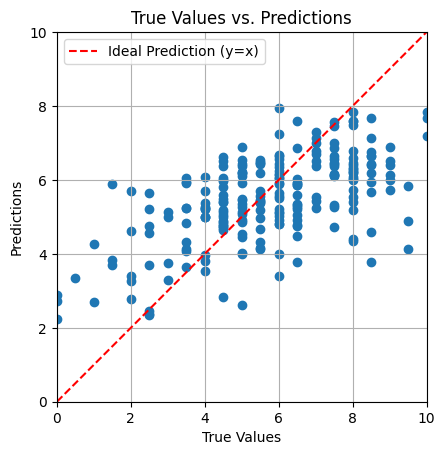

In [207]:
y_pred_test = model.predict(X_test)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_test)
plt.xlabel("True Values")
plt.ylabel("Predictions")

# 3. Đặt giới hạn cho trục x (xmin, xmax)
# Bắt đầu từ 0 và kết thúc ở 10
plt.xlim(0, 10)

# 4. Đặt giới hạn cho trục y (ymin, ymax)
# Bắt đầu từ 0 và kết thúc ở 10
plt.ylim(0, 10)

# Đảm bảo đường chéo nằm trong phạm vi mong muốn, ví dụ từ 0 đến 10
plt.plot([0, 10], [0, 10], color='red', linestyle='--', label='Ideal Prediction (y=x)')


# 6. Đặt tiêu đề cho biểu đồ
plt.title("True Values vs. Predictions")

# 7. (Tùy chọn) Đảm bảo tỷ lệ các trục bằng nhau để đường chéo nhìn đúng 45 độ
plt.gca().set_aspect('equal', adjustable='box')


# 8. Hiển thị biểu đồ
plt.grid(True) # Thêm lưới để dễ nhìn
plt.legend() # Hiển thị chú giải nếu có label
plt.show()